In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

params = {'mathtext.default': 'regular'}          
plt.rcParams.update(params)

## Search for similar materials using predicted PDOS fingerprints

### Load data

In [24]:
# Provide valid path to csv file with predicted PDOS for materials space
data_path = "../data/materials_space_pdos_fingeprints.csv.gz"

pdos_all_data_cdf = pd.read_csv(data_path)
pdos_all_data_cdf = pdos_all_data_cdf.loc[:, ~pdos_all_data_cdf.columns.str.contains('^Unnamed')]

id_prop = pd.read_csv("../data/materials_prop.csv")
id_prop.columns = ["id", "pretty_formula", "band_gap", "e_above_hull"]
print(id_prop)

                id  pretty_formula  band_gap  e_above_hull
0       mp-1184349          FeRhO3    0.0000      1.037876
1       mp-1221211         Na3WNO3    3.1819      0.118038
2        mp-540462         LiCrPO4    0.4112      0.041167
3          mp-8195        Ba2GeAs2    0.5786      0.000000
4        mp-505442          Mn3BO5    0.0000      0.011225
...            ...             ...       ...           ...
154713  mp-1518170       Sr2LaSbO6    3.6740      0.032425
154714   mp-558974      Pr5(RuO6)2    0.1922      0.000000
154715    mp-25310        Fe(PO3)3    2.8437      0.015117
154716   mp-778382  Li4Mn3Fe(BO3)4    2.6578      0.006414
154717      mp-801           Mo3Os    0.0000      0.011140

[154718 rows x 4 columns]


### Define procedure to search for similar materials

In [25]:
class SimilaritySearch():
    def __init__(self):
        gauss_filter = self._get_gaussian_filter(0, 4, -20, 10, 256)
        self.filter = np.concatenate((gauss_filter, gauss_filter, gauss_filter))

    def _get_gaussian_filter(self, mean, std, low, high, grid):
        x = np.linspace(low, high, grid)
        y = np.exp(-(x-mean)**2/(2*std**2))
        return y

    def get_similar_materials(self, pdos_all_data_cdf, pdos_predicted_cdf, n_materials=1000): 
        pdos_all_data_cdf_wd = pdos_all_data_cdf.copy()
        pdos_all_data_cdf_wd["Wasserstein distance"] = (pdos_all_data_cdf.loc[:, pdos_all_data_cdf.columns != 'id']-pdos_predicted_cdf).abs().sum(axis=1)
        max_wd = np.max(np.sort(np.array(pdos_all_data_cdf_wd["Wasserstein distance"]))[:n_materials])
        pdos_all_data_cdf_sorted = pdos_all_data_cdf_wd[pdos_all_data_cdf_wd["Wasserstein distance"] <= max_wd]

        return pdos_all_data_cdf_sorted

### Plot Density of States

In [26]:
def fill_under_lines(ax=None, alpha=.2, **kwargs):
    for line in ax.lines:
        x, y = line.get_xydata().T
        ax.fill_between(x, 0, y, color=line.get_color(), alpha=alpha, **kwargs)

def get_plot(df, ids, target_id):
    fig, axes = plt.subplots(len(ids), 1, sharex=True, figsize=(8, 2*len(ids)))

    for id, ax in zip(ids, axes):
        df_id = df[df["id"] == id]
        pdos_array = df_id.drop(["id", "Wasserstein distance", "pretty_formula", "band_gap", "e_above_hull"], axis=1).to_numpy()
        pdos_array = pdos_array.reshape(3, 256)
        pdos_array = np.diff(pdos_array, axis=1)
        pdos_array[pdos_array<0.0] = 0.0
        pdos_s = pdos_array[0]
        pdos_p = pdos_array[1]
        pdos_d = pdos_array[2] 
        total_dos = pdos_s + pdos_p + pdos_d
        pdos_df_id = pd.DataFrame({"Total DOS": total_dos, "s orbitals": pdos_s, "p orbitals": pdos_p, "d orbitals": pdos_d})

        pdos_df_id["Energy, eV"] = np.linspace(-20, 10, 256)[1:]
        pdos_df_id = pd.melt(pdos_df_id, id_vars="Energy, eV")
        pdos_df_id.columns = ["Energy, eV", "DOS type", "value"]

        sns.lineplot(x="Energy, eV", y="value", hue="DOS type", data=pdos_df_id, ax=ax, legend=True, palette=['darkorange', 'darkred', 'darkgreen', 'darkblue'])
        ax.set_xlabel("Energy, eV")
        ax.set_ylabel("PDOS, States/eV/Atom")

        handles, labels = ax.get_legend_handles_labels()
        formula = df[df["id"] == id]["pretty_formula"].to_list()[0]

        ax.legend(handles=handles[0:], labels=labels[0:], title = formula + f'\n{id}', fontsize=10, loc="upper right")
        fill_under_lines(ax)

    fig.tight_layout()

    if not os.path.exists(target_id):
        os.makedirs(target_id)

    plt.savefig(f"{target_id}/similar_materials_{target_id}.png", dpi=400)

### Find similar materials

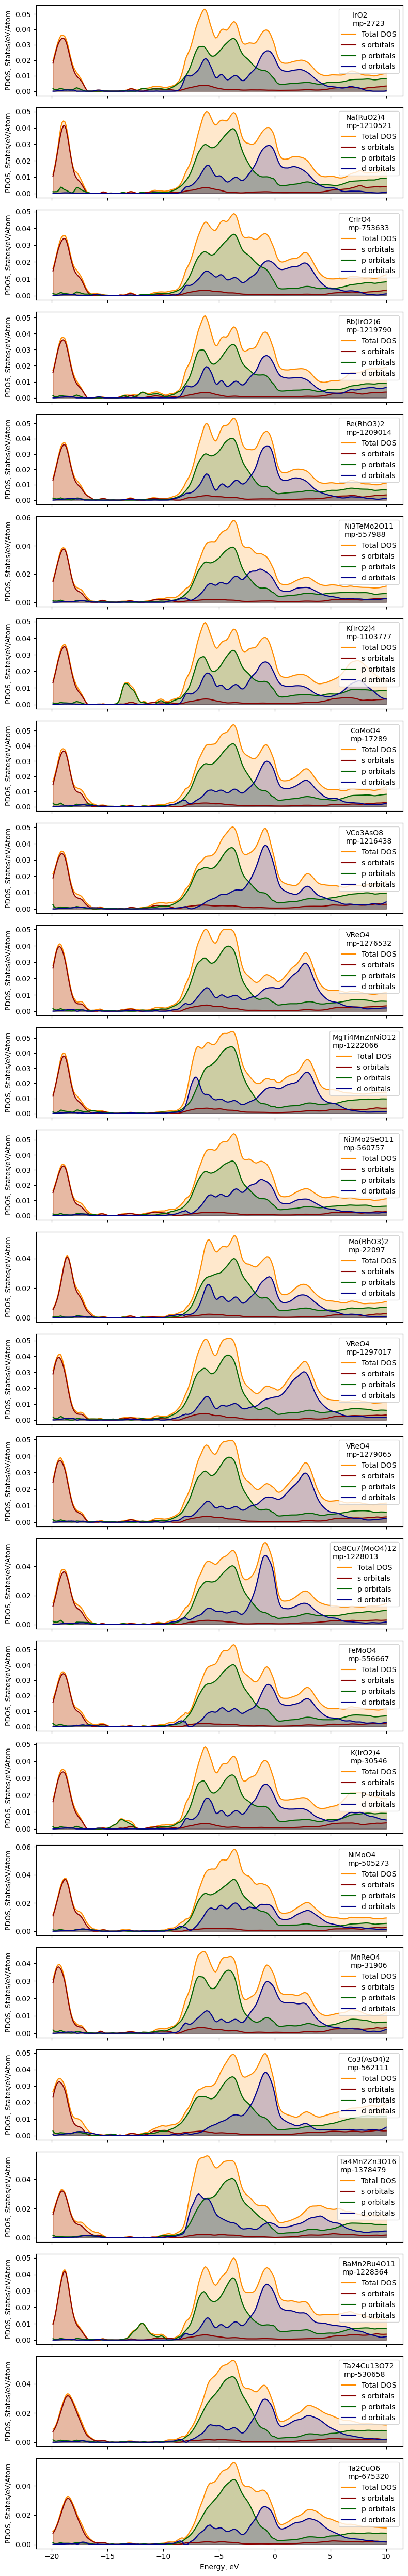

In [27]:
N_SIMILAR_MATERIALS = 1000
N_PLOT_MATERIALS = 25
E_ABOVE_HULL = 0.05

similarity_searh = SimilaritySearch()

# target ids
id_list = ["mp-2723"]

for id in id_list: 
    material_pdos = pdos_all_data_cdf[pdos_all_data_cdf["id"] == id].drop("id", axis=1).to_numpy()[0]

    similar_materials = similarity_searh.get_similar_materials(pdos_all_data_cdf, material_pdos, n_materials=N_SIMILAR_MATERIALS)
    similar_materials = similar_materials.sort_values("Wasserstein distance")

    similar_materials = similar_materials.merge(id_prop, on="id", how="inner")

    # Filter similar materials 
    similar_materials = similar_materials[(similar_materials["e_above_hull"] <= E_ABOVE_HULL) & 
                                          (similar_materials['pretty_formula'] != str(similar_materials[similar_materials["id"] == id]['pretty_formula'][0])) | 
                                          (similar_materials["id"] == id)]

    
    get_plot(similar_materials, ids=similar_materials["id"].to_list()[:N_PLOT_MATERIALS], target_id=id)
    plt.show()